# Data Processing

This notebook demonstrates how data processing has been carried out for the study.

Let's start with importing the required modules.

In [278]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.patches import Circle
# from matplotlib.collections import PatchCollection
# from matplotlib.lines import Line2D
# import matplotlib.colors as colors
import matplotlib
import mpl_axes_aligner

import metpy.calc as mpcalc
from metpy.units import units 
 
# import glob
from tqdm.notebook import tqdm
import seaborn as sb
import pandas as pd
import datetime
# sb.set_palette('Set2')
# from math import ceil
import scipy as sp
from pylab import shape,size
import string
from matplotlib.patches import ConnectionPatch
# import warnings

# import joanne
# from joanne.Level_4 import rgr_fn as rf
# from joanne.Level_4 import ready_ds_for_regression as prep
# from joanne.Level_4 import dicts

from src import plotting_functions as pf
from src import analysis as ay

import eurec4a

## Reading & Subsetting JOANNE Data
--------

For accessing [JOANNE](https://doi.org/10.5194/essd-13-5253-2021) data, we use the intake catalog set up for EUREC<sup>4</sup>A. 

<div class="alert alert-block alert-info">
The <a href="https://docs.ipfs.tech/concepts/content-addressing/#identifier-formats">content identifier (CID)</a>, an <a href="https://docs.ipfs.tech/concepts/what-is-ipfs/#decentralization">IPFS</a> hash in this case, is fixed for the study to make it as reproducible as possible. This CID is provided to the <a href="https://github.com/eurec4a/eurec4a-intake">EUREC<sup>4</sup>A intake catalog</a> with the <code>use_ipfs</code> argument. For JOANNE data, the provided CID links to v2.0.0.
</div>

In [279]:
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

For this notebook, we will only be needing Levels 3 & 4 of JOANNE. We use them as [Dask](https://docs.dask.org/en/stable/)-ified datasets as shown below.

In [280]:
jo_l3 = cat.dropsondes.JOANNE.level3.to_dask()
jo_l4 = cat.dropsondes.JOANNE.level4.to_dask()

We pick out selected EUREC<sup>4</sup>A circles for further analysis. See manuscript for details on EUREC<sup>4</sup>A circles.
<!-- 
<div class="alert alert-block alert-warning">
Note that one circle (circle ID <code>HALO-0215_c3</code>) during the flight on 15.02.2020 was flown over the NTAS buoy, farther east than the EUREC<sup>4</sup>A circle region. This does not qualify as a EUREC<sup>4</sup>A circle and therefore, we exclude it from any analyses.
</div> -->

For ease in analysis, we can also now swap dimensions of the dataset from `circle` to `circle_time` for including time in the dimension. This is possible because only one platform (`platform_id` = `HALO`) is now included in the data. Therefore, the time dimension will have unique coordinates.

In [5]:
eurec4a_circles = jo_l4.where(
    jo_l4.platform_id =='HALO',drop=True).swap_dims({'circle':'circle_time'}).sel(circle_time=slice('2020-01-20','2020-02-14'))

In [6]:
# Theta
eurec4a_circles['theta'] = mpcalc.potential_temperature(eurec4a_circles.p,eurec4a_circles.ta)

In [7]:
eurec4a_circles['q_ano'] = eurec4a_circles.q - eurec4a_circles.q.mean(dim='circle_time')
eurec4a_circles['D_ano'] = eurec4a_circles.D - eurec4a_circles.D.mean(dim='circle_time')

In [31]:
ano_vars = ['D','D_ano','q_ano']

resampled_mean = eurec4a_circles[ano_vars].resample(circle_time='1D').mean(
    dim='circle_time').dropna(dim='circle_time',how='all')

In [200]:
days = pd.DatetimeIndex(resampled_mean.circle_time.values)
ds_cirsets_ = []

for k in days.date.astype(str):
    ds_cirsets_.append(eurec4a_circles[ano_vars].sel(circle_time=k).isel(circle_time=slice(0,3)).mean(dim='circle_time'))
    ds_cirsets_[-1]['N'] = eurec4a_circles[ano_vars].sel(circle_time=k).isel(circle_time=slice(0,3)).circle_time.count().values

    ds_cirsets_.append(eurec4a_circles[ano_vars].sel(circle_time=k).isel(circle_time=slice(3,6)).mean(dim='circle_time'))
    ds_cirsets_[-1]['N'] = eurec4a_circles[ano_vars].sel(circle_time=k).isel(circle_time=slice(3,6)).circle_time.count().values

ds_cirsets = xr.concat(ds_cirsets_,dim='circling_set')

In [33]:
circles = {}
daily = {}
cirsets = {}

layers = {'sc':{'base':0,'top':600},
          'c':{'base':900,'top':1500},
          'cb':{'base':600,'top':900}}

for variable in ['D','D_ano','q_ano']:
    for layer in ['sc','c','cb']:
        for function in ['mean','std']:
            circles[f'{layer}_{variable}_{function}'] = ay.compute_over_layer(eurec4a_circles,variable,layers[layer]['base'],layers[layer]['top'],function)
            daily[f'{layer}_{variable}_{function}'] = ay.compute_over_layer(resampled_mean,variable,layers[layer]['base'],layers[layer]['top'],function)
            cirsets[f'{layer}_{variable}_{function}'] = ay.compute_over_layer(ds_cirsets,variable,layers[layer]['base'],layers[layer]['top'],function)

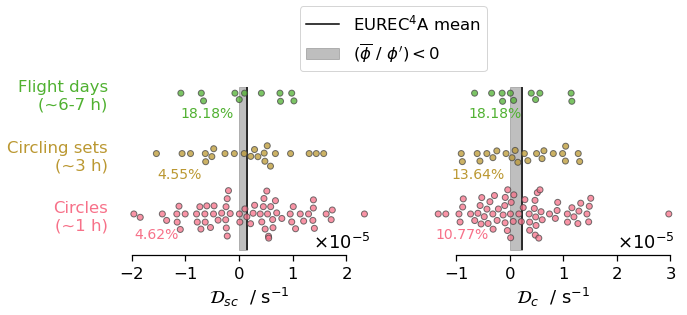

In [277]:
sb_color_palette = "husl"
sb.set_context('notebook',font_scale=1.5)
sb.set_palette(sb_color_palette)
f,ax = plt.subplots(1,2,figsize=(10,3),sharey=True)
ylim = (-.6,2.1)

for i,layer in enumerate(['sc','c']):

    variable = 'D'
    parameter = f'{layer}_{variable}_mean'
    parameter_ano = f'{layer}_{variable}_ano_mean'

    df = pd.concat([sample_type[parameter].to_series().reset_index(drop=True).rename(str(i)) for i,sample_type in enumerate([circles,cirsets,daily])],axis=1)

    sign_changes = np.array([sample_type[parameter].where(sample_type[parameter]/sample_type[parameter_ano] < 0,drop=True).count().values for sample_type in [circles,cirsets,daily]])

    all_conv_circles = np.array([sample_type[parameter].count().values for sample_type in [circles,cirsets,daily]])

    percent_circles = (sign_changes / all_conv_circles)*100

    sb.swarmplot(data=df,orient='h',ax=ax[i],s=6, marker="o", linewidth=1, alpha=.75,) #color='teal',
    ax[i].axvline(circles[parameter].mean(),c='k',label='EUREC$^4$A mean')
    ax[i].fill_betweenx(ylim,0,circles[parameter].mean(),
    color='grey',alpha=0.5,
    label = "$(\overline{\phi}\ /\ \phi') < 0$")
    
    ax[i].set_ylim(ylim)
    ax[i].set_xlabel(f"$\mathcal{{{variable}}}_{{{layer}}}$  / s$^{{{-1}}}$")

    [ax[i].text(ax[i].get_xlim()[0]*.9 - (y*ax[i].get_xlim()[0]/5),
    y-.4,
    f"{text:.2f}%",
    color=color,weight='regular',fontsize=14,
    ) for y,(text,color) in enumerate(zip(percent_circles,sb.color_palette(sb_color_palette).as_hex()[0:len(percent_circles)]))]
    
    pf.sci_exp_axis(ax[i],axis='x',x_pad=0.75)

ax[0].legend(loc=(.7,1.1))
ax[0].set_yticks([0,1,2],['Circles\n(~1 h)','Circling sets\n(~3 h)','Flight days\n(~6-7 h)'])
sb.despine(offset=5,trim=True)
[i.set_color(sb.color_palette(sb_color_palette).as_hex()[id_]) for id_,i in enumerate(ax[0].get_yticklabels())]
[m.spines['left'].set_visible(False) for m in ax]
[m.tick_params(axis='y',left=False)  for m in ax];

plt.savefig(f'sandbox/distribution_of_Dsc_and_Dc_for_circles_circling-sets_flight-days_compared_to_campaign_mean.pdf',bbox_inches='tight')

## Figure-1

We now have enough to create Figure-1, at least the parts that we would use `Python` for. 

Note that Figure-1 in the manuscript also includes some schematic drawings that are for conceptual understanding rather than data interpretation. These conceptual figures are made separately and are not included here.

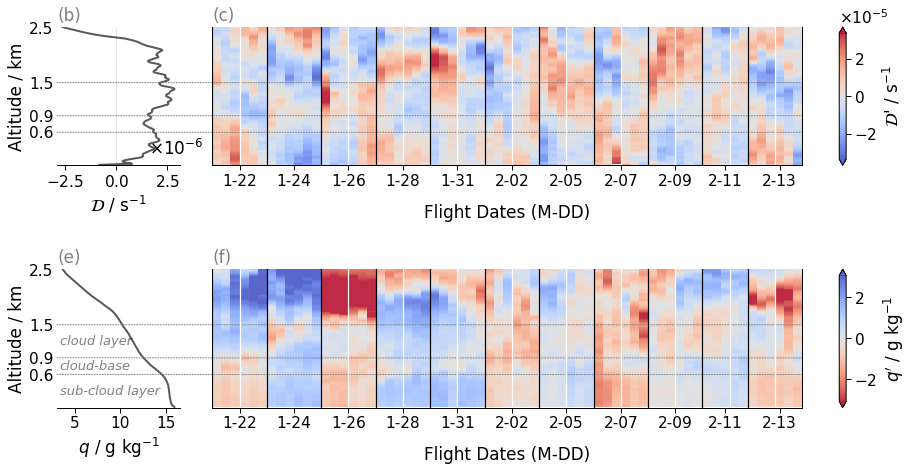

In [127]:
eurec4a_circles['q_1000'] = eurec4a_circles['q']*1000

pars = ['D','q_1000']
cbar_labels = ["$\mathcal{D}$\' / s$^{-1}$","$q\'$ / g kg$^{-1}$"]
mean_xlabels = ["$\mathcal{D}$ / s$^{-1}$","$q$ / g kg$^{-1}$"]

ylim = 2510

sb.set_context('paper',font_scale=1.75)
f,ax = plt.subplots(len(pars),2,figsize=(16,int(3.5*len(pars))),sharey=True, gridspec_kw={'width_ratios': [1,6]})
plt.subplots_adjust(wspace=0.075,hspace=0.75)

titles = list(string.ascii_lowercase)

for i in range(len(pars)) :
    
    if pars[i] == 'D':
        cm = plt.get_cmap('coolwarm').copy()
    else :
        cm = plt.get_cmap('coolwarm_r').copy()
    
    cb = (eurec4a_circles[pars[i]] - eurec4a_circles[pars[i]].mean(
        dim='circle_time')).swap_dims({'circle_time':'circle'}).plot.pcolormesh(
        y='alt',center=0,robust=True,cmap=cm,ax=ax[i,1],alpha=0.85,add_colorbar=False)

    ax[i,0].plot(eurec4a_circles[pars[i]].sel(alt=slice(0,ylim)).mean(dim='circle_time'),
                 eurec4a_circles.alt.sel(alt=slice(0,ylim)),linewidth=2,color='k',alpha=0.65)
    
    [ax[i,0].spines[m].set_visible(False) for m in ['right','top','left']]
    if i == 0:
        ax[i,0].axvline(0,color='grey',linestyle=':',linewidth=.5)
    
    pf.sci_exp_axis(ax[i,0],y_pad=0.075)
    
    ax[i,0].set_xlabel("")

    plt.ylim(0,ylim)

    min_circle = min(eurec4a_circles.circle.values)
    axv_ids = []
    days = []


    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel(mean_xlabels[i],labelpad=5)
    ax[i,1].set_xlabel('Flight Dates (M-DD)',labelpad=15)
    
    yticks = np.array([600,900,1500,2500])
    ax[i,1].set_yticks(yticks)
    ax[i,1].set_yticklabels(yticks/1000)
    ax[i,0].set_ylabel("Altitude / km")
    
    [ax[i,m].tick_params(axis='y', which=u'both',length=0) for m in range(2)]
    
    for id_, j in enumerate(eurec4a_circles.circle_time):    

        curr_date = pd.to_datetime(j.values).date()

        if id_ == 0:
            ax[i,1].axvline(min_circle + id_ - 0.5, c="k")
            ax[i,1].axvline(min_circle + id_ + 3 - 0.5, c="w")
            
            axv_ids.append(min_circle + id_ - 0.5)
            days.append(curr_date)
        elif curr_date != prev_date:
            ax[i,1].axvline(min_circle + id_ - 0.5, c="k")
            
            if (datetime.date(2020, 2, 15) == pd.DatetimeIndex(
                [j.values]).date[0]) :
                
                ax[i,1].axvline(min_circle + id_ + 2, c="w")
                
            elif (datetime.date(2020, 1, 24) == pd.DatetimeIndex(
                [j.values]).date[0]):
                pass
            else :
                ax[i,1].axvline(min_circle + id_ + 3 - 0.5, c="w")
            
            axv_ids.append(min_circle + id_ - 0.5)
            days.append(curr_date)
        if j == eurec4a_circles.circle_time.values[-1] :
            axv_ids.append(min_circle + id_ + 1.5)
            days.append(curr_date)

        prev_date = curr_date
        
    xticks = (np.array(axv_ids[1:]) + np.array(axv_ids[:-1]))/2
    xlabels = [
            f"{pd.to_datetime(days[j]).month:01d}-{pd.to_datetime(days[j]).day:02d}"
            for j in range(len(days[:-1]))
        ]

    ax[i,1].set_xticks(xticks)
    ax[i,1].set_xticklabels(xlabels)
    ax[i,1].spines['top'].set_visible(False)

    fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
    cbar = f.colorbar(cb, ax=ax[i,1], orientation="vertical", extend="both",label=cbar_labels[i],format=fmt)
    cbar.ax.yaxis.set_offset_position('left')

    [ax[i,m].set_title(f'({titles[int(i*3 + m + 1)]})',loc='left',weight='light',c='grey') for m in range(2)]
    
    # line over both plots
    xleft, _ = ax[i,0].get_xlim()
    _, xright = ax[i,1].get_xlim()
    
    for ht in [600,900,1500]:
        n_p_border = ConnectionPatch(xyA=(xleft,ht), xyB=(xright,ht), 
                                     coordsA='data', coordsB='data',
                                     axesA=ax[i,0], axesB=ax[i,1], lw=1,linestyle=':',color='grey')
        ax[i,1].add_artist(n_p_border)

ax[1,0].text(ax[1,0].get_xlim()[0]*1.1,300,'sub-cloud layer',fontsize=13,zorder=0,verticalalignment='center',color='grey',fontstyle='italic')
ax[1,0].text(ax[1,0].get_xlim()[0]*1.1,750,'cloud-base',fontsize=13,zorder=0,verticalalignment='center',color='grey',fontstyle='italic')
ax[1,0].text(ax[1,0].get_xlim()[0]*1.1,1200,'cloud layer',fontsize=13,zorder=0,verticalalignment='center',color='grey',fontstyle='italic')

plt.savefig(f'sandbox/EUREC4A_all_anomaly_parameters_div_q_upto_{ylim}_custom_yaxis_layers_shown.pdf',bbox_inches='tight')

## Reading in radiative profiles data
-----

We will also be using the radiative profiles dataset by [Albright et al (2021)](https://doi.org/10.5194/essd-13-617-2021). These are derived from EUREC<sup>4</sup>A's [radiosonde](https://doi.org/10.5194/essd-13-491-2021) and dropsonde (JOANNE) sounding data, and will supplement our analyses from JOANNE. 

Since we will only be using net longwave and net shortwave heating rates, we subset the dataset to the relevant variables, i.e. `q_rad_lw` and `q_rad_sw`.

In [128]:
rad_pars = ['q_rad_lw','q_rad_sw']
ds_rad = cat.radiative_profiles.clear_sky.to_dask()[rad_pars]

# Changing sounding_id from object to str for ease of use of dataset
ds_rad['sounding_id'] = ds_rad['sounding_id'].astype('str')

rad = [None] * len(eurec4a_circles.circle_time)

for i_,ct in enumerate(tqdm(eurec4a_circles.circle_time)):
    ds_ct = eurec4a_circles.sel(circle_time=ct)
    sonde_ids = ds_ct.sonde_id.where(ds_ct.sonde_id.astype('str') != '',drop=True).astype('str')
    sonde_ids_rad = [i.values for i in sonde_ids if i in ds_rad.sounding_id]
    rad[i_] = ds_rad.sel(sounding_id=sonde_ids_rad).mean(dim='sounding_id')
        
for par in rad_pars:
    eurec4a_circles[par] = xr.concat(rad[:],dim='circle_time')[par]

  0%|          | 0/65 [00:00<?, ?it/s]

/Users/geet/Documents/Repositories/Owned/recode_smocs/recode_smocs_env/lib/python3.8/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


IndexError: too many indices for array: array is 1-dimensional, but 13 were indexed

## Figure-2

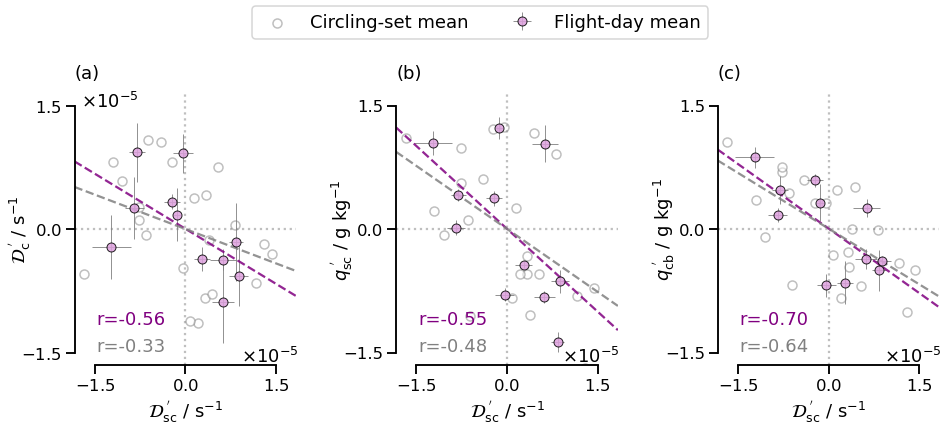

In [ ]:
sb.set_context('talk')

f,ax = plt.subplots(1,3,figsize=(15.5,5),sharex=True)
plt.subplots_adjust(wspace=0.45)
zero_line_kwargs = {'c':'grey','linestyle':':','alpha':0.5}

titles = list(string.ascii_lowercase)

D_unit = 's$^{-1}$'
q_unit = 'kg kg$^{-1}$'
x_par = 'sc_D_ano'

y_pars = {'c_D_ano':{'unit': 's$^{-1}$', 'label':'$\mathcal{D}_{\mathrm{c}}^{\ \'}$','scale_factor':1},
          'sc_q_ano':{'unit':'g kg$^{-1}$','label':'$q_{\mathrm{sc}}^{\ \'}$','scale_factor':10**3},
          'cb_q_ano':{'unit':'g kg$^{-1}$','label':'$q_{\mathrm{cb}}^{\ \'}$','scale_factor':10**3}}

for id_,y_par in enumerate(y_pars.keys()):

    ax[id_].errorbar(daily[f'{x_par}_mean'],
                     daily[f'{y_par}_mean']*y_pars[y_par]['scale_factor'],
                     yerr=daily[f'{y_par}_std']*y_pars[y_par]['scale_factor'],
                     xerr=daily[f'{x_par}_std'],
                     fmt='o',markeredgecolor='k',c='plum',alpha=0.85,ecolor='grey',elinewidth=1,label='Flight-day mean')

    ax[id_].scatter(cirsets[f'{x_par}_mean'],
                    cirsets[f'{y_par}_mean']*y_pars[y_par]['scale_factor'],
                    edgecolor='grey',c='white',alpha=0.5,label='Circling-set mean')

    pf.reg_line(ax[id_],
                daily[f'{x_par}_mean'],
                daily[f'{y_par}_mean']*y_pars[y_par]['scale_factor'],
                text_title=False,r_loc=(.1,.15),
                kwargs_for_text={"color":'purple','alpha':1},
                kwargs_for_axline={'color':'purple','linestyle':'--','alpha':0.85}) 

    pf.reg_line(ax[id_],
                cirsets[f'{x_par}_mean'],
                cirsets[f'{y_par}_mean']*y_pars[y_par]['scale_factor'],
                text_title=False,r_loc=(.1,.05),
                kwargs_for_text={"color":'grey','alpha':1},
                kwargs_for_axline={'color':'grey','linestyle':'--','alpha':0.85}) 

    ax[id_].set_title(f'({titles[id_]})',loc='left',pad=15,weight='light')

    ax[id_].axvline(0,**zero_line_kwargs) 
    ax[id_].axhline(0,**zero_line_kwargs) 

    pf.sci_exp_axis(ax[id_],axis='x',x_pad=0.75)
    _,y_exp = pf.sci_exp_axis(ax[id_],axis='y',x_pad=0.03,y_pad=.95) 

    ax[id_].set_xlabel('$\mathcal{D}_{\mathrm{sc}}^{\ \'}$ / s$^{-1}$')
    ax[id_].set_ylabel(f"{y_pars[y_par]['label']} / {y_pars[y_par]['unit']}",labelpad=-12)

    ax[id_].set_ylim([-1.65*10**(int(y_exp)),1.65*10**(int(y_exp))])
    ax[id_].set_yticks([-1.5*10**(int(y_exp)),0,1.5*10**(int(y_exp))])
    ax[id_].set_xticks([-1.5e-5,0,1.5e-5])

ax[1].legend(fontsize=18,frameon=True,loc=(-0.65,1.2),ncol=2)
sb.despine(trim=True)

mpl_axes_aligner.align.xaxes(ax[0], 0, ax[1], 0, 0.5)
mpl_axes_aligner.align.yaxes(ax[0], 0, ax[1], 0, 0.5)
mpl_axes_aligner.align.yaxes(ax[2], 0, ax[1], 0, 0.5)

plt.savefig('sandbox/subcloud_vs_cloud_subplots_abc_subplottitles.pdf',bbox_inches='tight')

The variables in the radiative dataset are given as heating profiles. We plot them as radiative cooling profiles in our manuscript and therefore, multiply it with -1 before plotting.

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

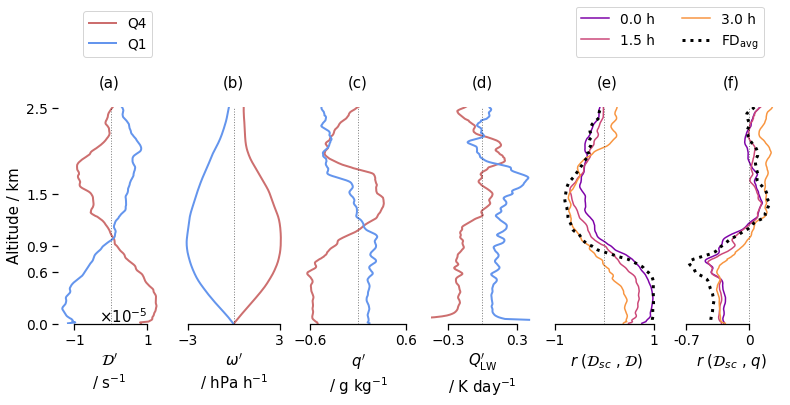

In [ ]:
ec_no24 = eurec4a_circles.drop_sel(circle_time=eurec4a_circles.sel(circle_time='2020-01-24').circle_time)

sb.set_context('notebook',font_scale=1.25)
sb.set_palette('plasma',n_colors=3)

jo_pars = ['D','omega','q','q_rad_lw',]
# era5_pars = ['D','w','q']

xlabels = ['$\mathcal{D}\'$\n/ s$^{-1}$',
           '$\omega\'$\n/ hPa h$^{-1}$',
          '$q\'$\n/ g kg$^{-1}$',
          '$Q_{\mathrm{LW}}\'$\n/ K day$^{-1}$']

a_factor = [1,36,10**3,-1] # coefficient to have correct units on axes #36 for omega

alt_low = 10
alt_high = 2510

f,ax = plt.subplots(1,6,sharey=True,figsize=(13,4))

p75 = ec_no24.D.sel(alt=slice(0,700)).mean(dim='alt').chunk({'circle_time': -1}).quantile(0.75)
p25 = ec_no24.D.sel(alt=slice(0,700)).mean(dim='alt').chunk({'circle_time': -1}).quantile(0.25)

# titles = 'abcd'

for id_,par in enumerate(jo_pars):
    
    mean = ec_no24[par].sel(alt=slice(alt_low,alt_high)).mean(dim=['circle_time']) * a_factor[id_]
    
    q4 = ec_no24[par].sel(alt=slice(alt_low,alt_high)).where(
        ec_no24.D.sel(alt=slice(0,700)).mean(dim='alt') > p75,drop=True).mean(
        dim=['circle_time']) * a_factor[id_]

    (q4 - mean).plot(ax=ax[id_],linewidth=2,y='alt',c='firebrick',label='Q4',alpha=0.65)
        
    q1 = ec_no24[par].sel(alt=slice(alt_low,alt_high)).where(
        ec_no24.D.sel(alt=slice(0,700)).mean(dim='alt') < p25,drop=True).mean(
        dim=['circle_time']) * a_factor[id_]
     
    (q1 - mean).plot(ax=ax[id_],linewidth=2,y='alt',c='cornflowerblue',label='Q1')
    
    if id_ != 0:
        ax[id_].yaxis.set_visible(False)
        
#     ax[id_].axvline(0,c='k',linewidth=1)
    
    ax[id_].set_xlabel(xlabels[id_])
    # ax[id_].set_title(f'{titles[id_]}',pad = 20)

ax[0].legend(loc=(0.25,1.23),ncol=1)    
sb.despine(left=True) #,trim=True,offset=6)
ax[0].yaxis.set_visible(True)
# ax[0].set_yticks(np.arange(0,alt_high+1,1000))
# ax[0].set_yticklabels(np.arange(0,(alt_high+1)/1000,1))
yticks = np.array([0,600,900,1500,2500])
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(yticks/1000)
ax[0].set_ylabel('Altitude / km')
ax[2].set_xlim(-0.65,0.65)
ax[3].set_xlim(-0.45,0.45)
ax[3].set_xticks([-0.3,0.3])
# ax[3].set_xticklabels([-0.3,0.3])

ax[2].set_xticks([-0.6,0.6])
# ax[2].set_xticklabels([-0.5,0.5])

ax[1].set_xticks([-3,3])
# ax[1].set_xticklabels([-0.1,0.1])

ax[0].set_xticks([-1e-5,1e-5])

### Vertical profile of r-values for D v/s sub-cloud D ###

dicts_with_all_leadlag_arrays = {0:{},1:{},2:{}}

subc_D = np.full(len(ec_no24.circle_time),np.nan)

for i in tqdm(range(len(ec_no24.circle_time))) :

    subc_D[i] = ec_no24.isel(circle_time=i).D.sel(alt=slice(0,600)).mean(dim='alt')

    dicts_with_all_leadlag_arrays[0][i] = ec_no24.isel(circle_time = i)

    dicts_with_all_leadlag_arrays[1][i] = ec_no24.where(
        (ec_no24.circle_time > ec_no24.circle_time[i]) 
           & (ec_no24.circle_time < ec_no24.circle_time[i] + np.timedelta64(90,'m')),drop=True)

    dicts_with_all_leadlag_arrays[2][i] = ec_no24.where(
        (ec_no24.circle_time > ec_no24.circle_time[i] + np.timedelta64(90,'m'))
           & (ec_no24.circle_time < ec_no24.circle_time[i] + np.timedelta64(180,'m')),drop=True)
    
r_jo_q = np.full((len(dicts_with_all_leadlag_arrays),len(ec_no24.alt)),np.nan) 
r_jo_d = np.full((len(dicts_with_all_leadlag_arrays),len(ec_no24.alt)),np.nan) 
arr_len = []

for kd_,key in enumerate(tqdm(np.sort(np.array(list(dicts_with_all_leadlag_arrays.keys()))))) :

    a = np.array([size(dicts_with_all_leadlag_arrays[key][i].D) 
                  for i in dicts_with_all_leadlag_arrays[key]])
    b = np.where(a != 0)

    arr = xr.concat([dicts_with_all_leadlag_arrays[key][i] 
                     for i in dicts_with_all_leadlag_arrays[key]],dim='circle_time')        
    
    arr_len.append(len(arr.circle_time))

    x = subc_D[b]

    for id_,i in enumerate(tqdm(arr.alt,leave=False)) :

        y = arr.sel(alt=i).q.values
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        if sum(~nas) > 1 :
            r_jo_q[kd_,id_], _ = sp.stats.pearsonr(x[~nas],y[~nas]) 
        
        y = arr.sel(alt=i).D.values
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        if sum(~nas) > 1 :
            r_jo_d[kd_,id_], _ = sp.stats.pearsonr(x[~nas],y[~nas]) 

for i in range(3) :
    ax[5].plot(r_jo_q[i],arr.alt,label=f'{i*1.5} h')
    
for i in range(3) :
    ax[4].plot(r_jo_d[i],arr.alt,label=f'{i*1.5} h')   
    
# Dropsondes

low_alt = 50 
high_alt = 3300

res_ec_no24_D = ec_no24.D.resample(circle_time='1D').mean()

x = res_ec_no24_D.sel(alt=slice(0,600)).mean(dim='alt')
r_jo = [None] * len(res_ec_no24_D.alt.sel(alt=slice(low_alt,high_alt)))

for i,alt in enumerate(tqdm(ec_no24.alt.sel(alt=slice(low_alt,high_alt)))) :
    
    y = res_ec_no24_D.sel(alt=alt)
    
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    
    r_jo[i], _ = sp.stats.pearsonr(x[~nas],y[~nas]) 
    
# Plotting

ax[4].plot(r_jo,res_ec_no24_D.alt.sel(alt=slice(low_alt,high_alt)),
         label='FD$_{\mathrm{avg}}$',linewidth=3,c='k',linestyle=':',alpha=1)
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('$r$ ($\mathcal{D}_{sc}$ , $\mathcal{D}$)')
# ax[4].set_title('e',pad = 20)
ax[4].set_xlim(-1,1.1)
ax[4].set_xticks([-1,1])
 
### Vertical profile of r-values for q v/s sub-cloud D ###

# Dropsondes

low_alt = 50 
high_alt = 3300

res_ec_no24_D = ec_no24.D.resample(circle_time='1D').mean()
res_ec_no24_q = ec_no24.q.resample(circle_time='1D').mean()

x = res_ec_no24_D.sel(alt=slice(0,600)).mean(dim='alt')
r_jo = [None] * len(res_ec_no24_D.alt.sel(alt=slice(low_alt,high_alt)))

for i,alt in enumerate(tqdm(ec_no24.alt.sel(alt=slice(low_alt,high_alt)))) :
    
    y = res_ec_no24_q.sel(alt=alt)
    
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    
    r_jo[i], _ = sp.stats.pearsonr(x[~nas],y[~nas]) 
        
#### Plotting #####

ax[5].plot(r_jo,res_ec_no24_D.alt.sel(alt=slice(low_alt,high_alt)),
         c='k',linestyle=':',linewidth=3,label='FD$_{\mathrm{avg}}$',alpha=1)
ax[5].set_xlabel('$r$ ($\mathcal{D}_{sc}$ , $q$)')
ax[5].yaxis.set_visible(False)
# ax[5].set_title('f',pad = 20)
ax[5].set_xlim(-.78,.38)
ax[5].set_xticks([-.7,0])
ax[5].set_xticklabels([-.7,0])
ax[5].set_ylim(0,2510)

ax[4].legend(ncol=2,loc=(.2,1.23))

sb.despine(trim=True)

pf.sci_exp_axis(ax[0],axis='x',x_pad=.4)

[ax[i].spines['left'].set_visible(False) for i in range(6)]
[ax[i].axvline(0,c='k',alpha=0.5,linewidth=1,linestyle=':') for i in range(6)]
[ax[i].set_title(f'({titles[i]})',pad = 20) for i in range(len(ax))];
plt.savefig('sandbox/composites_and_vertical_profiles_of_r_with_time-lagged_profiles_custom_yticks_without_HALO-0124.pdf',bbox_inches='tight')